[<< Previous: Data Preparation](01_initial_data_prep.ipynb) &nbsp; | &nbsp; [Next: Model Fitting >>](03_rating_pred.ipynb)

# Exploratory dataset analysis

In this notebook, we will conduct some high-level exploratory analysis of our dataset before fitting our model. Due to the simplicity and readability of `tidyverse` syntax, as well as the convenient features of `ggplot` and `dplyr`, we will use the `R` language and `tidyverse` tools for this analysis.

First, let's import the libraries that will be required for this notebook.

In [1]:
library(tidyverse)
library(yaml)

── Attaching core tidyverse packages ───────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Configurations

Before we do our analysis, let's make sure we are retrieving the configurations for the appropriate experiment.

In [2]:
config_id <- "mlml6_rate_pred_clsp"

In [3]:
main_config <- yaml.load_file(paste0("../experiments/configs/", config_id, "/main.yaml"))
dataset_id <- main_config$dataset_id

## Load data

Let's load in the summary dataframe we saved out previously.

In [4]:
df <- read_csv(paste0("../data/pitchfork/", dataset_id, "/summary_df.csv"))

Rows: 22063 Columns: 8
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (6): artist, album, reviewer, genre, label, reviewed
dbl (2): rating, review_n_tokens

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Before moving on, we should do a quick check to make sure the data look like we expect them to.

In [5]:
df %>% head()

artist,album,rating,reviewer,genre,label,reviewed,review_n_tokens
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
Joni Mitchell,Joni Mitchell at Newport,6.0,Grayson Haver Currin,Rock,Rhino,"July 29, 2023",721
The Clientele,I Am Not There Anymore,8.0,Marc Hogan,Rock,Merge,"July 28, 2023",718
Nas,Magic 2,6.5,Dylan Green,Rap,Mass Appeal,"July 28, 2023",736
Beverly Glenn-Copeland,The Ones Ahead,8.0,Jesse Dorris,Experimental,Transgressive,"July 28, 2023",704
Damon Locks,New Future City Radio,6.9,Matthew Blackwell,Jazz / Experimental,International Anthem,"July 28, 2023",797
DJ K,PANICO NO SUBMUNDO,7.9,Nadine Smith,Experimental,Nyege Nyege Tapes,"July 27, 2023",682


## Exploratory analysis

We are going to do some exploratory analysis of our dataset. We will do this to make sure that the preprocessing yielded a high quality dataset, and to get a sense of some general characteristics of the data.

In [6]:
# Settings for plots
options(repr.plot.width = 16, repr.plot.height = 8, repr.plot.res = 100)

In [7]:
# Helpers to avoid redundant code
set_theme_elements <- function(plt) {
    plt +
        theme_classic() +
        theme(text = element_text(size=16))
}

## Spot checks

First we want to do some basic quality checks to make sure our preprocessing was successful.

### Duplicate check

Let's make sure that our removal of duplicates was successful, since we do not want there to be any duplicates when we fine-tune our model. Let's make sure there are no duplicate reviews by checking to make sure `"album"`, `"artist"`, `"rating"`, `"reviewer"`, and `"reviewed"` are not repeated. It could be that an album was reviewed multiple times - review platforms are known to "revisit" material. However, if we find an instance where the same album by a given artist was given the same rating by the same reviewer on the same date as a pre-existing review, this could point to an issue that got past us in our pre-processing step.

In [8]:
df %>%
    add_count(album, artist, rating, reviewer, reviewed) %>%
    filter(n > 1) %>%
    nrow()

[1] 0

It seems that we were able to successfully remove duplicate rows from our data.

## Key investigations

### Distribution of token counts

The first item of interest is to investigate the distribution of `"review"` token counts. Our model has a maximum sequence length of 512 tokens and we noticed that many reviews exceeded this limit.

We will look at a quantile table and then a visualization of token counts.

In [9]:
df %>%
    pull(review_n_tokens) %>%
    quantile() %>%
    as_tibble(rownames="quantile")

quantile,value
<chr>,<dbl>
0%,17
25%,631
50%,707
75%,804
100%,1231


Let's use a density plot rather than a histogram since bin-widths sometimes have a distorting effect on clarity.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


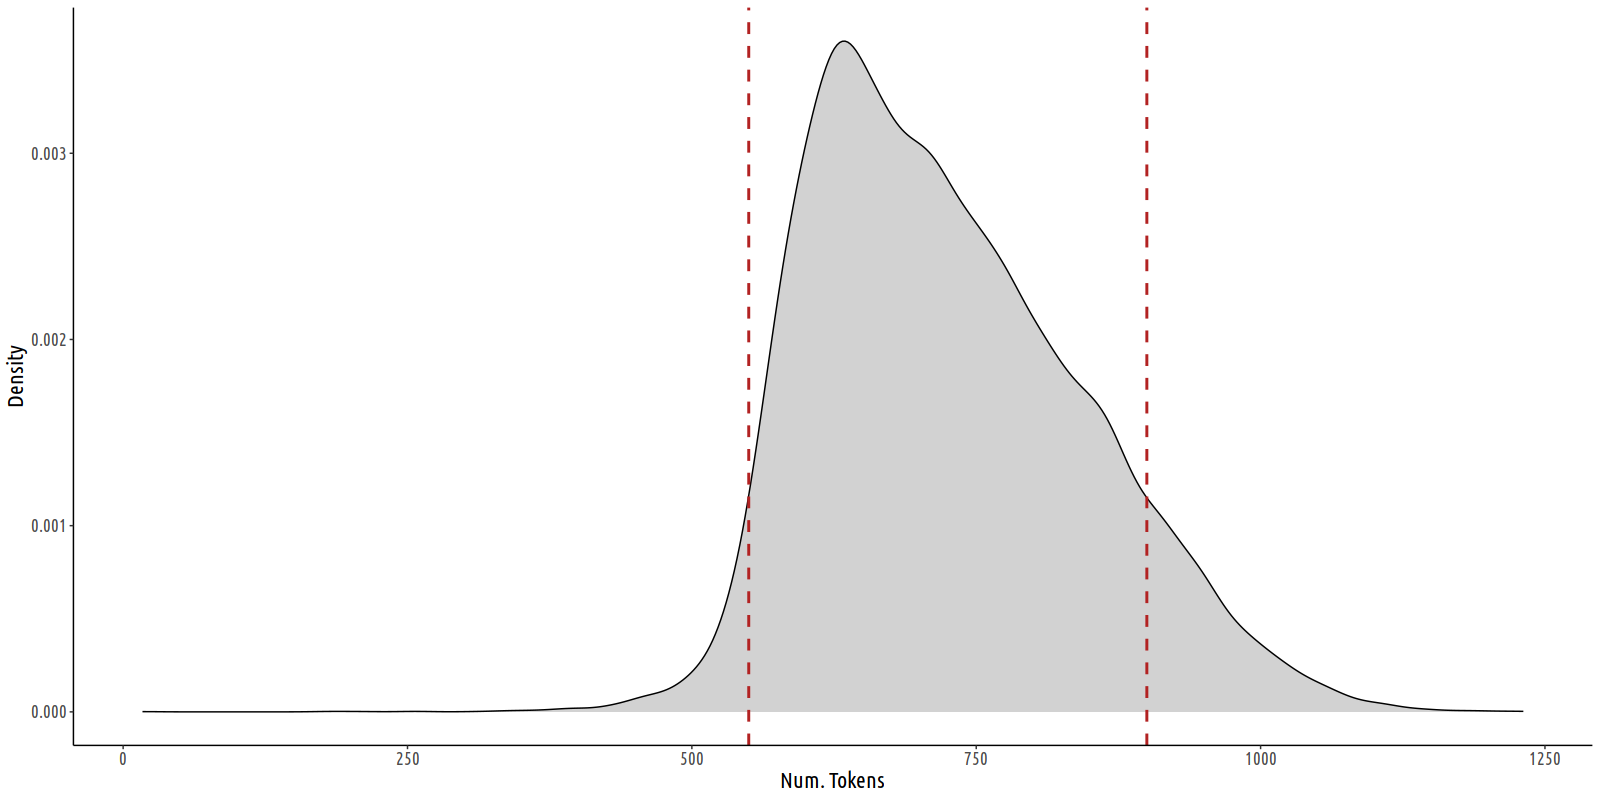

In [10]:
plt <- df %>%
    ggplot() +
    geom_density(aes(review_n_tokens), alpha=0.7, fill="gray") +
    geom_vline(xintercept=550, linetype="dashed", color="firebrick", size=1.0) +
    geom_vline(xintercept=900, linetype="dashed", color="firebrick", size=1.0)

plt <- plt %>%
    set_theme_elements() +
    xlab("Num. Tokens") +
    ylab("Density")

plt

It appears that the vast majority of reviews fall between 500 and 1000 tokens, with most having between roughly 550 and 900 tokens. This will need to be addressed when we fit our model, but for now, we will just make a note of it.

### Distribution of ratings

Next, let's take a look at the distribution of ratings among the reviews.

In [11]:
df %>%
    pull(rating) %>%
    quantile() %>%
    as_tibble(rownames="quantile")

quantile,value
<chr>,<dbl>
0%,0.0
25%,6.6
50%,7.3
75%,7.8
100%,10.0


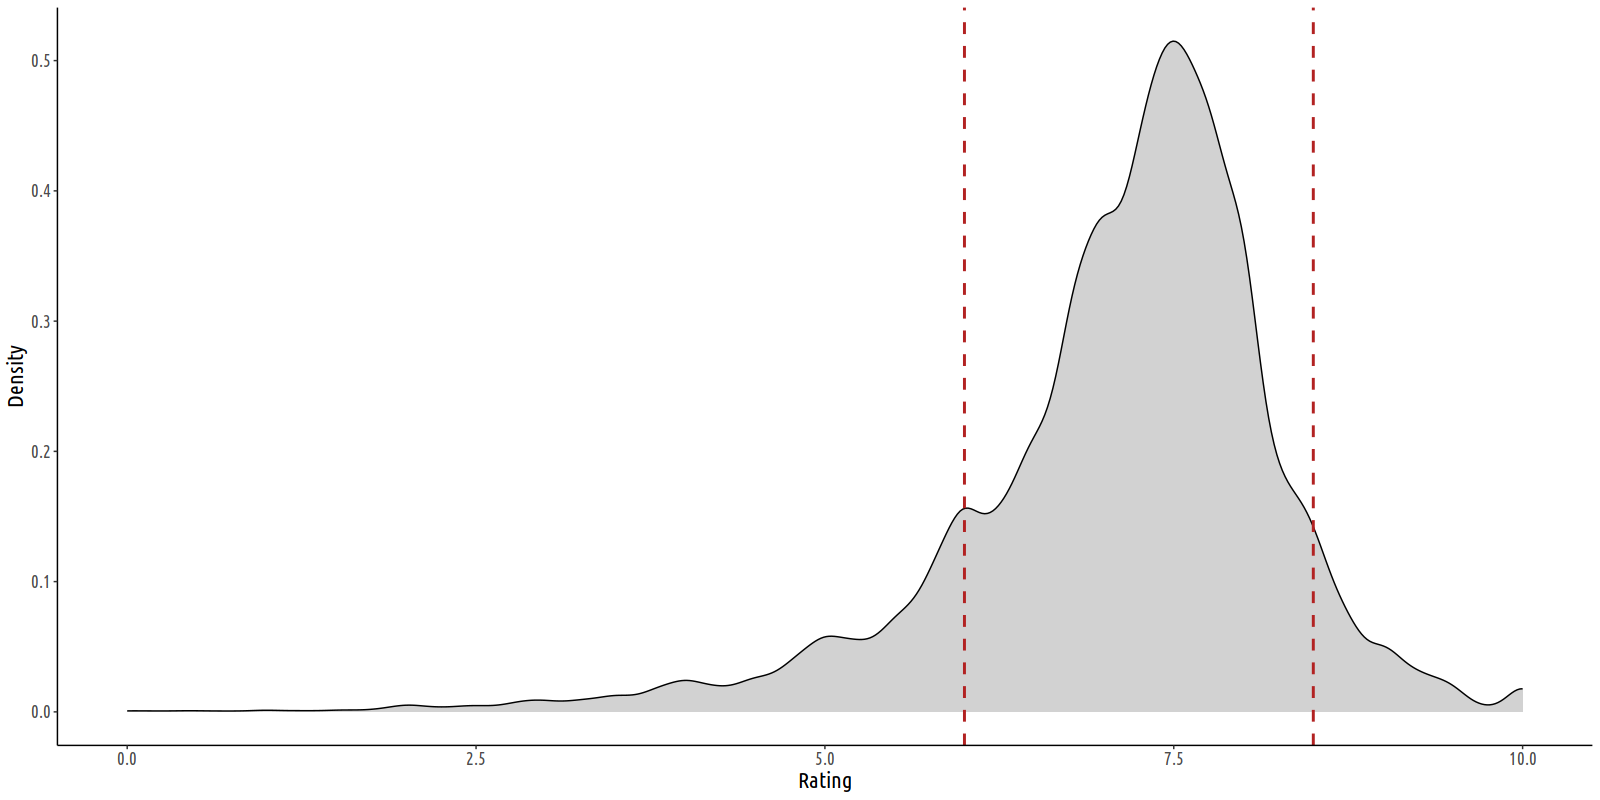

In [12]:
plt <- df %>%
    ggplot() +
    geom_density(aes(rating), alpha=0.7, fill="gray") +
    geom_vline(xintercept=6, linetype="dashed", color="firebrick", size=1.0) +
    geom_vline(xintercept=8.5, linetype="dashed", color="firebrick", size=1.0)

plt <- plt %>%
    set_theme_elements() +
    xlab("Rating") +
    ylab("Density")

plt

We see that the vast majority of ratings cluster within the range $[6,8.5]$. This may cause bias in our regression model, so it will be important to evaluate this after fitting our model.

## Other investigations

### Unique artists

Many artists will have multiple albums present in the dataset. How many unique artists are there?

In [13]:
n_artists <- df %>%
    distinct(artist) %>%
    nrow()
n_artists

[1] 10242

How does this compare to the overall number of rows in our dataset?

In [14]:
n_rows <- df %>%
    nrow()

round(n_rows / n_artists, digits = 2)

[1] 2.15

### Artist album counts

What does the distribution of album counts look like for each artist?

In [15]:
album_count_df <- df %>%
    # Mindful of albums with multiple reviews
    distinct(artist, album) %>%
    count(artist, name = "n_albums")

In [16]:
album_count_df %>%
    pull(n_albums) %>%
    quantile() %>%
    as_tibble(rownames="quantile")

quantile,value
<chr>,<dbl>
0%,1
25%,1
50%,1
75%,2
100%,711


It appears we have an extreme outlier at the $100$th percentile mark. Let's investigate the cause.

In [17]:
album_count_df %>%
    arrange(desc(n_albums)) %>%
    head()

artist,n_albums
<chr>,<int>
Various Artists,711
Neil Young,33
Gucci Mane,25
Guided by Voices,25
Bob Dylan,24
David Bowie,23


Even the legendary Neil Young cannot compete with "Various Artists" in terms of output. Let's remove this from the summary data to get a better sense of the distribution.

In [18]:
album_count_df <- album_count_df %>%
    filter(artist != "Various Artists")

In [19]:
album_count_df %>%
    pull(n_albums) %>%
    quantile() %>%
    as_tibble(rownames="quantile")

quantile,value
<chr>,<dbl>
0%,1
25%,1
50%,1
75%,2
100%,33


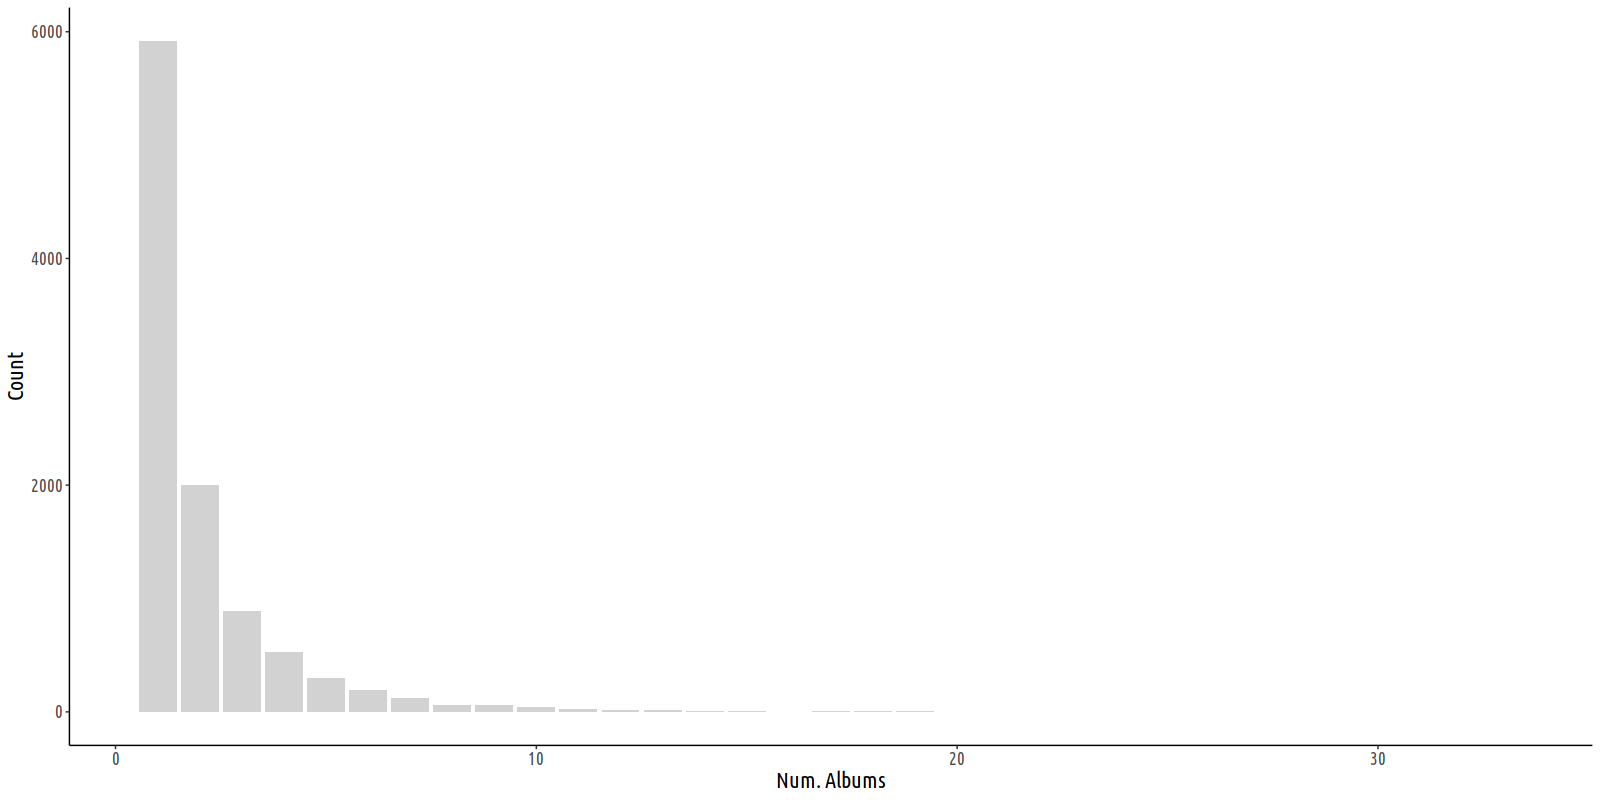

In [20]:
plt <- album_count_df %>%
    ggplot() +
    geom_bar(aes(n_albums), alpha=0.7, fill="gray")

plt <- plt %>%
    set_theme_elements() +
    xlab("Num. Albums") +
    ylab("Count")

plt

We see that it is quite rare for an artist to have more than even 2 albums in this dataset.

### Multiple reviews

How many of the albums in this dataset have multiple reviews?

In [21]:
df %>%
    count(artist, album, name = "n_reviews") %>%
    filter(n_reviews > 1) %>%
    nrow()

[1] 10

This turns out to be a very small number.

### Distribution of review counts per reviewer

What does the distribution of review counts look like for the reviewers in our dataset?

Because the number of reviewers is in the hundreds, we can use "rain cloud" plots for extra information about how many points lie at each peak.

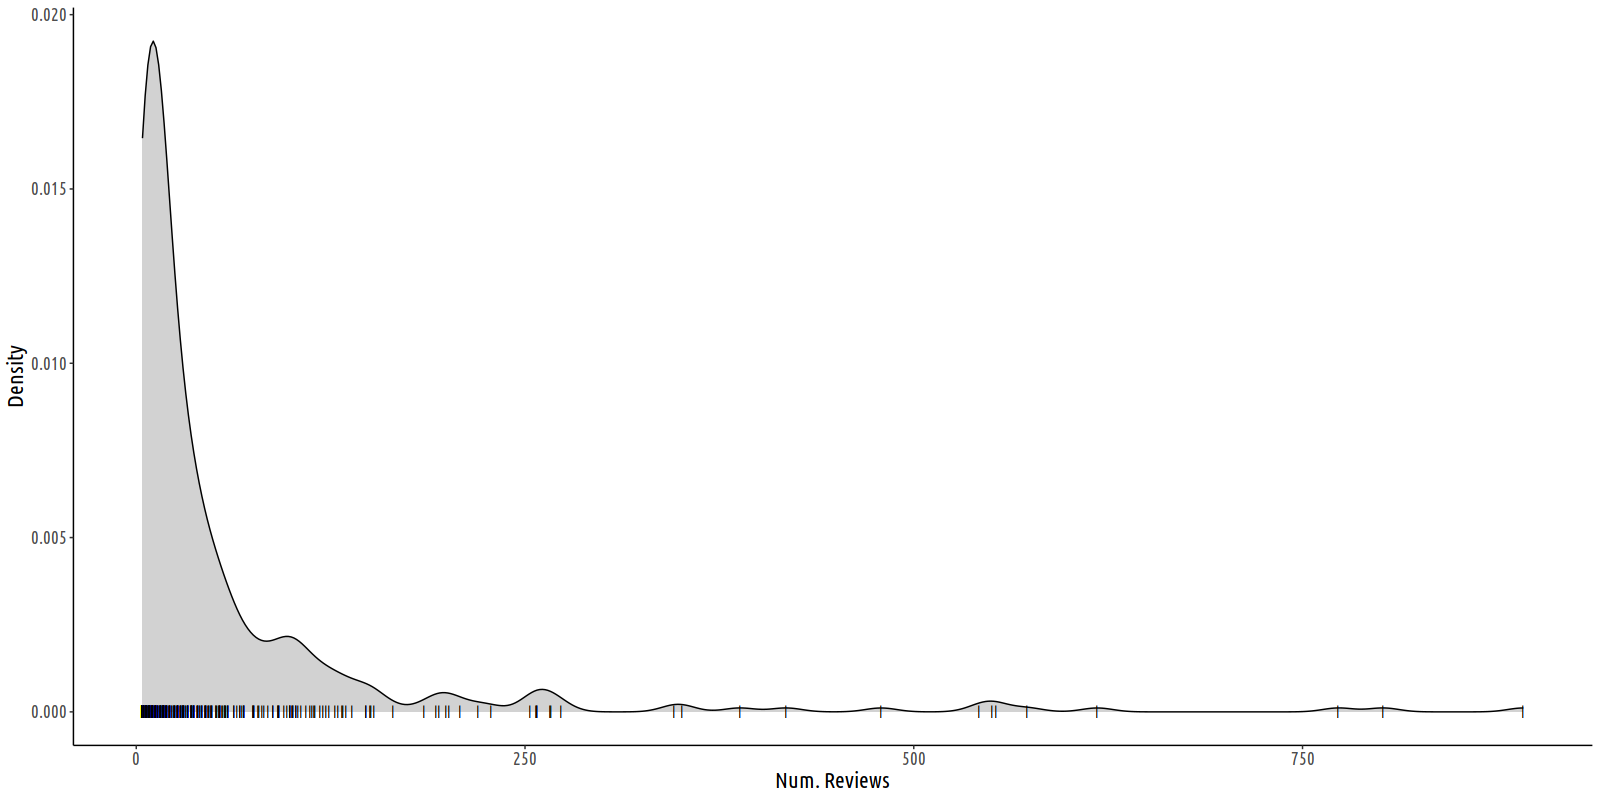

In [22]:
plt <- df %>%
    count(reviewer, name="n_reviews") %>%
    # Filter out reviewers with very few reviews
    filter(n_reviews > 3) %>%
    ggplot() +
    geom_density(aes(n_reviews), alpha=0.7, fill="gray") +
    geom_point(aes(x=n_reviews, y=0), shape="|", size=3)

plt <- plt %>%
    set_theme_elements() +
    xlab("Num. Reviews") +
    ylab("Density")

plt

### Distribution of average rating among reviewers

How harsh are the reviewers on average? Is this average harshness skewed?

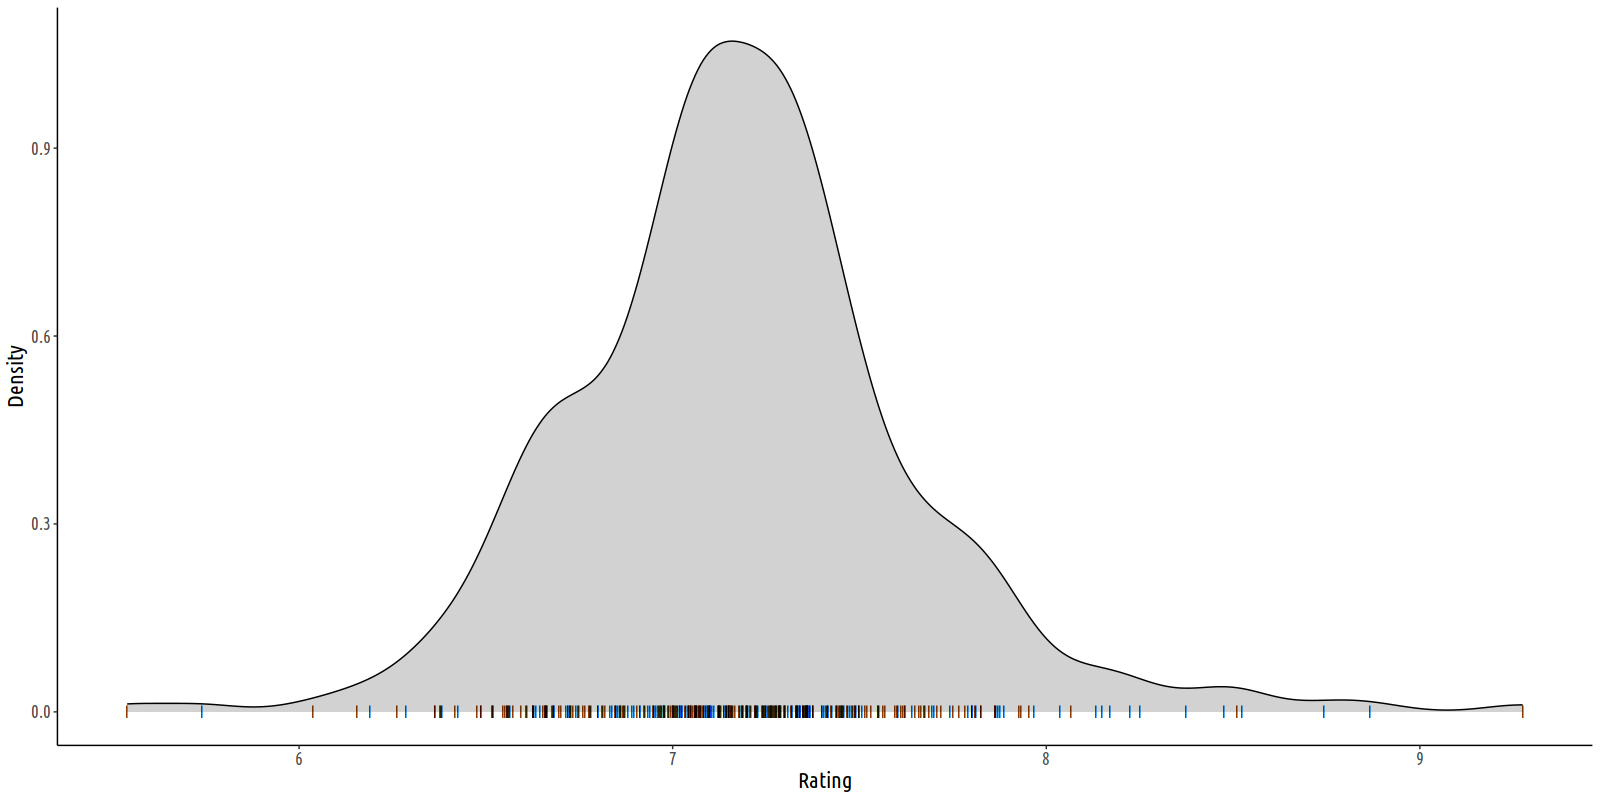

In [23]:
plt <- df %>%
    group_by(reviewer) %>%
    summarize(mean_rating = mean(rating), n_ratings = n()) %>%
    filter(n_ratings > 3) %>%
    ggplot() +
    geom_density(aes(mean_rating), alpha=0.7, fill="gray") +
    geom_point(aes(x=mean_rating, y=0), shape="|", size=3)

plt <- plt %>%
    set_theme_elements() +
    xlab("Rating") +
    ylab("Density")

plt

### The National - where do they stand?

How does the iconic indie rock band The National measure up to other bands in the dataset?

In [24]:
tnl_med_rating <- df %>%
    filter(artist == "The National") %>%
    summarize(median_rating = median(rating)) %>%
    pull(median_rating)
tnl_med_rating

[1] 7.95

Not bad! The median rating of The National falls above the $75$th percentile of reviews in the dataset. What happens when we compare their median rating to the ratings of other prolific artists in the dataset?

In [25]:
df %>%
    filter(artist != "The National") %>%
    add_count(artist, name = "n_album_reviews") %>%
    filter(n_album_reviews > 5) %>%
    group_by(artist) %>%
    summarize(median_rating = median(rating)) %>%
    pull(median_rating) %>%
    quantile() %>%
    as_tibble(rownames = "quantile")

quantile,value
<chr>,<dbl>
0%,4.00
25%,6.95
50%,7.40
75%,7.80
100%,9.50


Impressive! Their median rating is well above the $75$th percentile of median reviews for bands with more than 5 album reviews.

[<< Previous: Data Preparation](01_initial_data_prep.ipynb) &nbsp; | &nbsp; [Next: Model Fitting >>](03_rating_pred.ipynb)